In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import cPickle as pickle
from spiketopics.helpers import *

%matplotlib inline
sns.set_style('darkgrid')

# Load in data

In [2]:
infile = 'data/fitted_model_object.pkl'
gpm = pickle.load(open(infile, 'rb'))
dt = 0.020

In [3]:
gpm.Nframe.head()

,unit,time,count,lam0,lam1
0,2,364,1,-0.965725,-0.965649
1,8,364,1,-0.875764,-0.887432
2,0,364,0,-0.451104,-0.428505
3,0,364,1,-0.526288,-0.552219
4,0,364,0,-0.451104,-0.428505


In [4]:
if gpm.regressors:
    gpm.Xframe.head()

# Plot inferred categories as matrix

In [5]:
xi = gpm.nodes['HMM'].nodes['z'].z[1].copy()
T, K = xi.shape
print xi.shape

(624, 10)


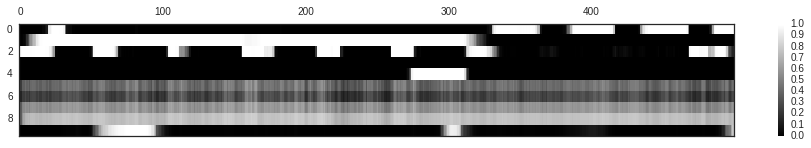

In [6]:
matshow(xi[:500].T, vmin=0, vmax=1);
plt.colorbar();

## Make $\xi$ dataframe:

In [7]:
xif = pd.DataFrame(xi)
xif.columns = ['Z' + str(k) for k in range(K)]
xif.index.name = 'time'
xif = xif.reset_index()

# Posteriors for effects

## Baselines

In [8]:
bl = gpm.nodes['baseline']
unit_baseline_means = bl.expected_x() / dt

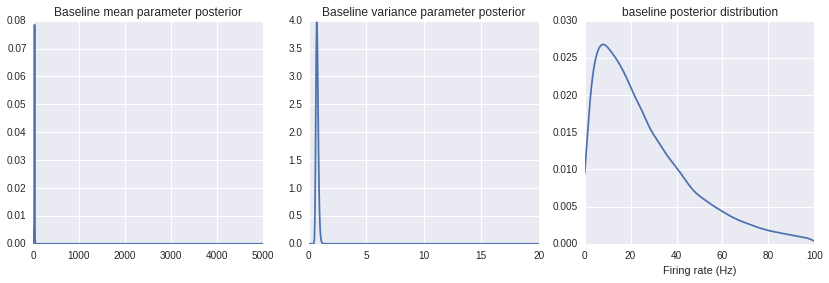

In [9]:
plt.figure(figsize=(14, 4))

th = gpm.nodes['baseline_mean']
cc = gpm.nodes['baseline_shape']
th_pars = [th.post_shape, th.post_rate]
cc_pars = [cc.post_shape, cc.post_rate]
samples = gamma_from_hypers(th_pars, cc_pars, 1e5)

plt.subplot(1, 3, 1)
xx = np.linspace(0, 5000, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0], scale=th_pars[1]/dt))
plt.title('Baseline mean parameter posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 20, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0], scale=cc_pars[1]))
plt.title('Baseline variance parameter posterior');

plt.subplot(1, 3, 3)
sns.kdeplot(samples / dt, gridsize=1e4, clip=(0, 100))
plt.title('baseline posterior distribution')
plt.xlabel('Firing rate (Hz)')
plt.xlim(0, 100);

## Regressors

In [10]:
if gpm.regressors:
    plt.figure(figsize=(8, 6));
    inferred_means = gpm.nodes['fr_regressors'].expected_x()
    R = inferred_means.shape[1]
    for r in xrange(R):
        plt.hist(inferred_means[:, r], bins=50, normed=True, alpha=0.25, label='X' + str(r))
    plt.title('Regression effects');
    plt.legend()
    plt.ylim(0, 5);
    plt.xlim(0, 5);

## Latent Categories

In [11]:
frn = gpm.nodes['fr_latents']
fr_mean_effect = frn.expected_x()

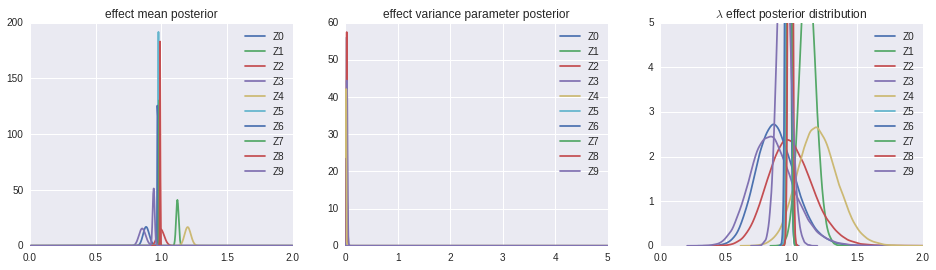

In [12]:
plt.figure(figsize=(16, 4))

th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']

th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

plt.subplot(1, 3, 1)
xx = np.linspace(0, 2, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0, kk], scale=th_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect mean posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 5, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0, kk], scale=cc_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect variance parameter posterior');

plt.subplot(1, 3, 3)
for kk in xrange(K):
    samples = gamma_from_hypers(th_pars[:, kk], cc_pars[:, kk], 1e5)
    sns.kdeplot(samples, gridsize=1e4, clip=(0, 10), label='Z' + str(kk))
plt.legend()
plt.title(r'$\lambda$ effect posterior distribution')
plt.xlim(0, 2);
plt.ylim(0, 5);

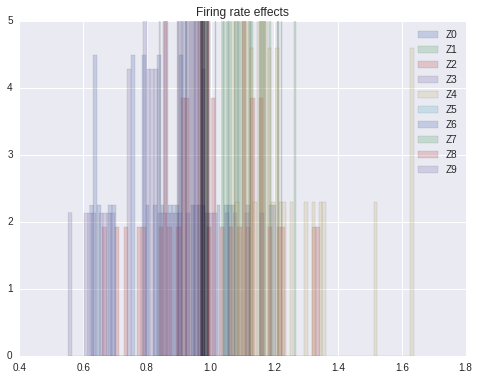

In [13]:
plt.figure(figsize=(8, 6))

inferred_effects = gpm.nodes['fr_latents'].expected_x()
for kk in xrange(K):
    plt.hist(inferred_effects[..., kk], bins=50, normed=True, alpha=0.25, label='Z' + str(kk));
plt.legend();
plt.title('Firing rate effects');
plt.ylim(0, 5);

## Overdispersion

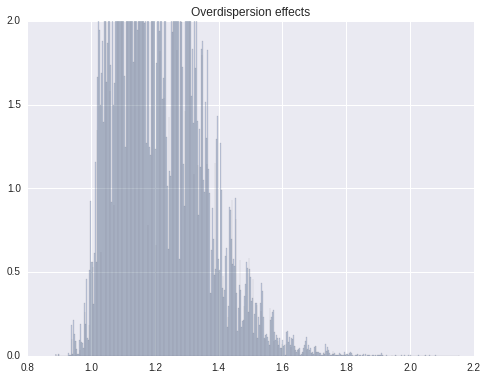

In [14]:
if gpm.overdispersion:
    plt.figure(figsize=(8, 6))

    inferred_means = gpm.nodes['overdispersion'].expected_x().ravel()
    plt.hist(inferred_means, bins=500, normed=True, alpha=0.25);
    plt.title('Overdispersion effects');
    plt.ylim(0, 2);

# Load and prepare coded features:

Our goal here is to load the ethogram, join it to the inferred ethogram, and perform some comparisons to see if any of our discovered categories match hand-labeled categories from the ethogram.

In [15]:
codefile = 'data/roitman_fd_data.csv'
code = pd.read_csv(codefile).groupby('utime').mean().reset_index()

In [16]:
code.head()

,utime,count,time,trial,stimulus,coherence,fixation_on,fixation,target_on,stim_on,...,Xstim,Xcoh0,Xcoh32,Xcoh64,Xcoh128,Xcoh256,Xcoh512,Xinto,Xout,into_RF
0,0,0.595890,0,32.89726,71,0,0,52.547945,460.438356,903.780822,...,0,0,0,0,0,0,0,0,0,1
1,1,0.780822,20,32.89726,71,0,0,52.547945,460.438356,903.780822,...,1,1,0,0,0,0,0,1,0,1
2,2,0.636986,40,32.89726,71,0,0,52.547945,460.438356,903.780822,...,1,1,0,0,0,0,0,1,0,1
3,3,0.746575,60,32.89726,71,0,0,52.547945,460.438356,903.780822,...,1,1,0,0,0,0,0,1,0,1
4,4,0.623288,80,32.89726,71,0,0,52.547945,460.438356,903.780822,...,1,1,0,0,0,0,0,1,0,1


In [17]:
# convert bools to floats
for col in code:
    code[col] = code[col].astype('float')

In [18]:
# merge labeled and inferred etho on movie and frame columns
edf = pd.merge(code, xif, how='right', left_on='utime', right_on='time')
edf.columns

Index([u'utime', u'count', u'time_x', u'trial', u'stimulus', u'coherence', u'fixation_on', u'fixation', u'target_on', u'stim_on', u'stim_off', u'fixation_off', u'saccade', u'reward', u'choice', u'correct', u'unit', u'Xstim', u'Xcoh0', u'Xcoh32', u'Xcoh64', u'Xcoh128', u'Xcoh256', u'Xcoh512', u'Xinto', u'Xout', u'into_RF', u'time_y', u'Z0', u'Z1', u'Z2', u'Z3', u'Z4', u'Z5', u'Z6', u'Z7', u'Z8', u'Z9'], dtype='object')

In [19]:
# get rid of categories that are either identifiers or have non-binary entries
to_drop = [col for col in edf.columns if not ('Z' in col or 'X' in col)]
edf = edf.drop(to_drop, axis=1)

In [20]:
edf.head()

,Xstim,Xcoh0,Xcoh32,Xcoh64,Xcoh128,Xcoh256,Xcoh512,Xinto,Xout,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9
0,0,0,0,0,0,0,0,0,0,0.000321,0.005294,0.898357,2.216577e-04,0.000025,0.044452,0.044899,0.042627,0.040423,0.004727
1,1,1,0,0,0,0,0,1,0,0.000042,0.010022,0.989109,2.758467e-06,0.000034,0.237831,0.142847,0.359761,0.368477,0.001844
2,1,1,0,0,0,0,0,1,0,0.000245,0.013803,0.996827,1.455081e-05,0.000003,0.371807,0.236694,0.519177,0.565290,0.001821
3,1,1,0,0,0,0,0,1,0,0.000005,0.027780,0.999943,4.378792e-08,0.000015,0.370202,0.231253,0.533235,0.646563,0.001509
4,1,1,0,0,0,0,0,1,0,0.000121,0.058748,0.999523,1.601518e-06,0.000003,0.425541,0.278344,0.580638,0.706122,0.002282


# Compare actual and predicted firing

In [21]:
# make dataframe of firing rates
meancnt = code.groupby(['time', 'stimulus']).mean()['count'].unstack(level=1)
fr = pd.rolling_mean(meancnt, 9, min_periods=1, center=True) / dt

In [22]:
# calculate predicted firing rate
pred_mat = unit_baseline_means[np.newaxis, :] * np.exp(xi.dot(np.log(fr_mean_effect.T)))
preds = np.mean(pred_mat, axis=1)  # mean across units
code['pred_fr'] = preds * np.mean(gpm.nodes['overdispersion'].expected_x())

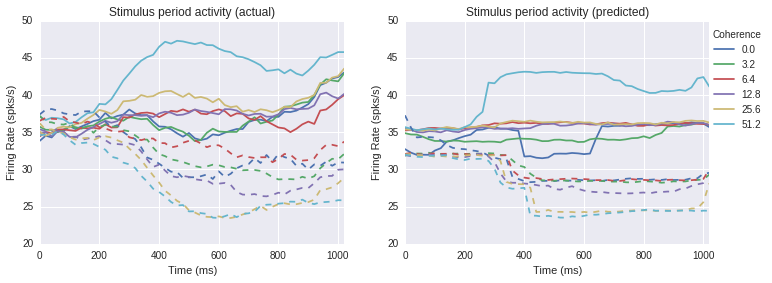

In [23]:
plt.figure(figsize=(12, 4))

##### first, do actual
ax = plt.subplot(1, 2, 1)

# label cols according to coherence, RF
coh_tbl = code[['stimulus', 'coherence', 'into_RF']].drop_duplicates()
colnames = []
for idx, row in coh_tbl.iterrows():
    coh_str = str(row['coherence'] / 10)
    colnames.append(coh_str)

fr.columns = colnames
midpt = int(fr.shape[1] / 2)
fr.iloc[:, :midpt].plot(ax=ax, legend=False)
fr.iloc[:, midpt:].plot(ax=ax, legend=False, linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (spks/s)')
plt.title('Stimulus period activity (actual)')
yl = plt.ylim()

##### now do predicted
ax = plt.subplot(1, 2, 2)

# data frame of predicted firing for each stimulus
pred_df = code.groupby(['time', 'stimulus']).mean()['pred_fr'].unstack(level=1)

# plot
midpt = int(pred_df.shape[1] / 2)
pred_df.iloc[:, :midpt].plot(ax=ax, legend=False)
pred_df.iloc[:, midpt:].plot(ax=ax, legend=False, linestyle='--')
plt.ylim(yl)
ax.legend(colnames[:midpt], bbox_to_anchor=(1.2, 1.00), title='Coherence');
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (spks/s)')
plt.title('Stimulus period activity (predicted)');

# View results:

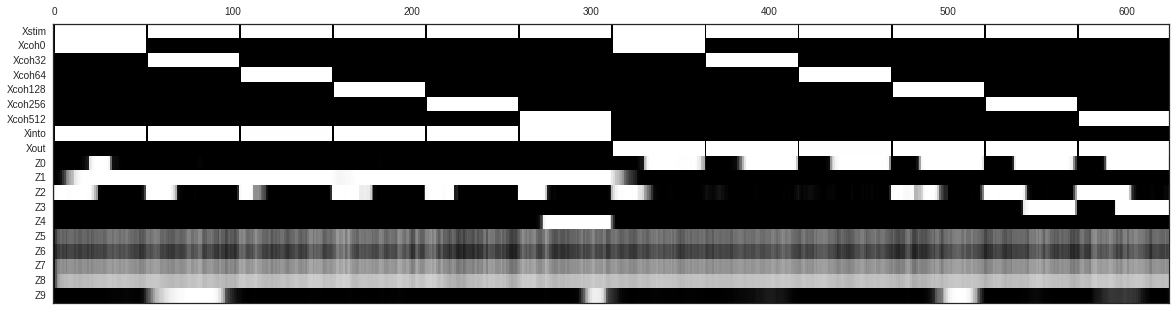

In [24]:
# plot a section in time; each row is a regressor; bottom rows are inferred categories
trng = slice(None)
matshow(edf.iloc[trng].values.T, vmin=0, vmax=1);
col_labels = edf.columns
plt.yticks(xrange(len(col_labels)), col_labels);
plt.gcf().set_size_inches([20, 5])

## Overlap analysis:

Define the overlap as the maximum of the match or mismatch percentage. That is, if $x$ and $y$ are binary vectors, 
$$
\mathrm{overlap} = \max \{ \mathbb{E}[xy + (1-x)(1-y)], \mathbb{E}[(1-x)y + x(1-y)]\}
$$

In [25]:
match = (edf.T.dot(edf) + (1 - edf.T).dot(1 - edf)) / T
mismatch = (edf.T.dot(1 - edf) + (1 - edf.T).dot(edf)) / T
overlap = np.maximum(match, mismatch)

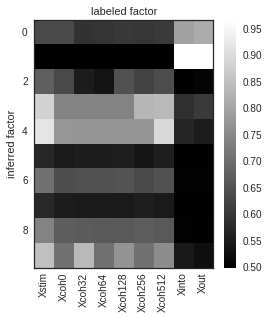

In [26]:
row_labels = edf.columns[:-K]
matshow(overlap.values[-K:,:-K]) #, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

In [27]:
overlap.iloc[-K:, :]

,Xstim,Xcoh0,Xcoh32,Xcoh64,Xcoh128,Xcoh256,Xcoh512,Xinto,Xout,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9
Z0,0.635682,0.637069,0.591879,0.596464,0.605853,0.599271,0.606850,0.794691,0.813899,0.979902,0.801871,0.551941,0.748123,0.592068,0.530095,0.573807,0.519647,0.573736,0.611872
Z1,0.502458,0.501357,0.502740,0.502722,0.501735,0.502766,0.502693,0.967821,0.967482,0.801871,0.984869,0.502138,0.594105,0.565020,0.502370,0.502777,0.501805,0.501734,0.541679
Z2,0.674481,0.634926,0.552342,0.535136,0.650747,0.623993,0.642342,0.502968,0.508034,0.551941,0.502138,0.955709,0.603709,0.610393,0.525808,0.572594,0.525857,0.585456,0.593037
Z3,0.883870,0.739649,0.739652,0.739640,0.739645,0.834211,0.838831,0.586867,0.606961,0.748123,0.594105,0.603709,0.998095,0.840479,0.563638,0.676471,0.561435,0.700591,0.783575
Z4,0.919429,0.774501,0.773909,0.773902,0.773919,0.773912,0.897216,0.570707,0.551914,0.592068,0.565020,0.610393,0.840479,0.996495,0.566695,0.687896,0.567737,0.718232,0.843741
Z5,0.572701,0.549394,0.553710,0.554520,0.556829,0.542170,0.557205,0.501800,0.502924,0.530095,0.502370,0.525808,0.563638,0.566695,0.520304,0.542288,0.505973,0.534506,0.561600
Z6,0.707462,0.642912,0.648098,0.648207,0.652139,0.635220,0.650840,0.504383,0.505493,0.573807,0.502777,0.572594,0.676471,0.687896,0.542288,0.603527,0.527497,0.604377,0.664890
Z7,0.576319,0.554018,0.550882,0.550017,0.549021,0.558241,0.548035,0.500897,0.500235,0.519647,0.501805,0.525857,0.561435,0.567737,0.505973,0.527497,0.516523,0.542117,0.553785
Z8,0.742356,0.670776,0.667358,0.665210,0.665539,0.671434,0.665489,0.504609,0.503114,0.573736,0.501734,0.585456,0.700591,0.718232,0.534506,0.604377,0.542117,0.628220,0.682158
Z9,0.851334,0.709630,0.839262,0.706150,0.772067,0.706656,0.759260,0.546245,0.527846,0.611872,0.541679,0.593037,0.783575,0.843741,0.561600,0.664890,0.553785,0.682158,0.939490
